# Intuition behind Classification 
## Prefer Confidence Intervals to Point Estimates

It is usually a good idea to get an estimate of confidence in your prediction in addition to producing the prediction itself. For regression analysis this usually takes the form of predicting a range of values that is calibrated to cover the true value 95% of the time or in the case of classification it could be just a matter of producing class probabilities. This becomes more crucial with small data sets as it becomes more likely that certain regions in your feature space are less represented than others. Model averaging as referred to in the previous two points allows us to do that pretty easily in a generic way for regression, classification and density estimation. It is also useful to do that when evaluating your models. Producing confidence intervals on the metrics you are using to compare model performance is likely to save you from jumping to many wrong conclusion

In [76]:
#Load the librarys
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
# Import StandardScaler from scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime, date
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings('ignore')

In [2]:
# Read spreadsheet and assign it to swiss_loan
swiss_loan= pd.read_excel('C:/Users/rzouga/Desktop/ALLINHERE/Assignement/ATUCE_Case_study_data_2021.xlsx')

In [30]:
# Create a boolean mask on whether each feature less than 40% missing values.
mask = swiss_loan.isna().sum() / len(swiss_loan) < 0.4
# Create a reduced dataset by applying the mask
reduced_df =swiss_loan.loc[:, mask]

# drop ID
reduced_df.drop('ID', axis=1, inplace=True)
reduced_df['Pays_corr']=reduced_df['Pays'].str.strip()
reduced_df['Taux_corr']=reduced_df['Taux'].str.replace('%','').str.strip().str.replace(',','.').str.extract(r'(\d+.\d+)')
reduced_df['Taux_corr'] = np.where(reduced_df['Taux_corr'].isnull(), 0.1, reduced_df['Taux_corr'])
reduced_df['Taux_corr'] = pd.to_numeric(reduced_df['Taux_corr'], errors='coerce')
# Specify the boundaries of the bins
bins = [0.001,5.5,  6.5, 10]
# Bin labels
labels = [ 'Low', 'Medium', 'High']
# Bin the continuous variable ConvertedSalary using these boundaries
reduced_df['Taux_corr_binned'] = pd.cut(reduced_df['Taux_corr'], 
                                         bins=bins,labels=labels )
# Print the first 5 rows of the boundary_binned column
reduced_df['Montant_corr']=reduced_df['Montant'].str.replace('€','').str.replace('\xa0','').str.strip().str.replace('\s+','')
reduced_df['Montant_corr'] = np.where(reduced_df['Montant_corr'].isnull(), 0.1, reduced_df['Montant_corr'])
reduced_df['Montant_corr'] = pd.to_numeric(reduced_df['Montant_corr'], errors='coerce')
reduced_df['Niveau_risque_corr']=reduced_df['Niveau de risque'].str.rstrip().str.replace('\s+','')
Emprunteurs = reduced_df['Emprunteur']


Emprunteurs_counts = Emprunteurs.value_counts()

# Create a mask for only categories that occur less than 5 times
mask = Emprunteurs.isin(Emprunteurs_counts[Emprunteurs_counts<5].index)
# Label all other categories as Other
reduced_df['Emprunteur'][mask] = 'Other'
reduced_df['capital_social_corr']=reduced_df['capital social'].str.replace('€','').str.replace('\xa0','').str.strip().str.replace('\s+','')
reduced_df['capital_social_corr'] = np.where(reduced_df['capital_social_corr'].isnull(), 0.1, reduced_df['capital_social_corr'])
reduced_df['capital_social_corr'] = pd.to_numeric(reduced_df['capital_social_corr'], errors='coerce')

reduced_df['Effectifse_corr']=reduced_df['effectifs'].str.rstrip().str.replace('\s+','')
reduced_df['Effectifse_corr'][reduced_df['Effectifse_corr'] == '-'] = np.nan

reduced_df['Nombre_mois_période16_corr']=reduced_df['Nombre de mois de la période 16'].str.rstrip().str.replace('mois','').str.replace(',','.').str.replace('\s+','').str.extract(r"(\d+\.\d+|\d+)")
reduced_df['Nombre_mois_période16_corr'][reduced_df['Nombre_mois_période16_corr'] == '-'] = np.nan
reduced_df['Nombre_mois_période16_corr'] = pd.to_numeric(reduced_df['Nombre_mois_période16_corr'], errors='coerce')

reduced_df['Chiffre_Affaires_16_corr']=reduced_df.iloc[:,12].str.replace('\xa0','').str.strip().str.replace('\s+','')
reduced_df['Chiffre_Affaires_16_corr'] = pd.to_numeric(reduced_df['Chiffre_Affaires_16_corr'], errors='coerce')

reduced_df['Total_Bilan_16_corr']= reduced_df['Total Bilan 16'].str.replace('\xa0','').str.strip().str.replace('\s+','').str.extract(r"([-+]?\d*\.*\d+|\d+)")
reduced_df['Total_Bilan_16_corr']= pd.to_numeric(reduced_df['Total_Bilan_16_corr'], errors='coerce')

reduced_df['Capacité_remboursement_FCCR_16_corr']= reduced_df['Capacité de remboursement (FCCR) 16'].str.replace('\xa0','').str.strip().str.replace('\s+','').str.replace(',','.').str.extract(r"([-+]?\d*\.*\d+|\d+)")
reduced_df['Capacité_remboursement_FCCR_16_corr']= pd.to_numeric(reduced_df['Capacité_remboursement_FCCR_16_corr'], errors='coerce')


reduced_df['Fonds_Propres_16_corr']= reduced_df['Fonds Propres 16'].str.replace('\xa0','').str.strip().str.replace('\s+','').str.replace(',','.').str.extract(r"([-+]?\d*\.*\d+|\d+)")
reduced_df['Fonds_Propres_16_corr']= pd.to_numeric(reduced_df['Fonds_Propres_16_corr'], errors='coerce')

reduced_df['Fonds_Propres_Total_Bilan_corr']= reduced_df['Fonds Propres / Total Bilan 16'].str.replace('\xa0','').str.strip().str.replace('\s+','').str.replace(',','.').str.replace('%','').str.extract(r"([-+]?\d*\.*\d+|\d+)")
reduced_df['Fonds_Propres_Total_Bilan_corr']= pd.to_numeric(reduced_df['Fonds_Propres_Total_Bilan_corr'], errors='coerce')

reduced_df['Dettes_Nettes_EBE_16_corr']= reduced_df['Dettes Nettes / EBE(* années) 16'].str.replace('\xa0','').str.strip().str.replace('\s+','').str.replace(',','.').str.replace('*','').str.extract(r"([-+]?\d*\.*\d+|\d+)")
reduced_df['Dettes_Nettes_EBE_16_corr']= pd.to_numeric(reduced_df['Dettes_Nettes_EBE_16_corr'], errors='coerce')

reduced_df['DettesNettes_Fonds_propres_16_corr']= reduced_df['Dettes Nettes / Fonds propres 16'].str.replace('\xa0','').str.strip().str.replace('\s+','').str.replace(',','.').str.replace('%','').str.extract(r"([-+]?\d*\.*\d+|\d+)")
reduced_df['DettesNettes_Fonds_propres_16_corr']= pd.to_numeric(reduced_df['DettesNettes_Fonds_propres_16_corr'], errors='coerce')


# Apply the log normalization function 
reduced_df['Montant_corr_log'] = np.log(reduced_df['Montant_corr'])

# Apply the log normalization function 
reduced_df['Chiffre_Affaires_16_corr_log'] = np.log(reduced_df['Chiffre_Affaires_16_corr'])
# Apply the log normalization function t
reduced_df['capital_social_corr_log'] = np.log(reduced_df['capital_social_corr']+1)
# This function converts given date to age
def age(creation):
    born = int(creation)
    today = date.today()
    return today.year - born
  
reduced_df['Age'] = reduced_df['année de création'].apply(age)

In [31]:
list_to_keep= [ 'Pays_corr','Mois','Age' ,'Taux_corr', 'Taux_corr_binned', 'Montant_corr_log',
       'Niveau_risque_corr','Emprunteur', 'capital_social_corr_log', 'Effectifse_corr',
       'Nombre_mois_période16_corr', 'Capacité_remboursement_FCCR_16_corr','Total_Bilan_16_corr',
       'Fonds_Propres_16_corr', 'Fonds_Propres_Total_Bilan_corr',
       'Dettes_Nettes_EBE_16_corr', 'DettesNettes_Fonds_propres_16_corr','Chiffre_Affaires_16_corr_log']
clean_reduced_df= reduced_df[list_to_keep].copy()
clean_reduced_df.shape

(688, 18)

# Classification Target 

Low       390
Medium    158
High      140
Name: Taux_corr_binned, dtype: int64


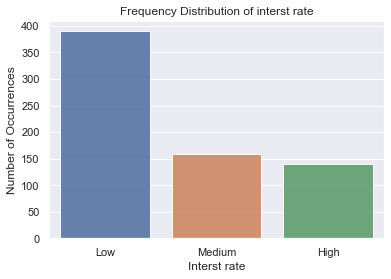

In [32]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
# Create a series out of the Country column
Taux_binned = reduced_df['Taux_corr_binned']

# Get the counts of each category
Taux_counts = Taux_binned.value_counts()

# Print the count values for each category
print(Taux_counts)
sns.set(style="darkgrid")
sns.barplot(Taux_counts.index, Taux_counts.values, alpha=0.9)
plt.title('Frequency Distribution of interst rate')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Interst rate', fontsize=12)
plt.show()

# X and y

In [33]:
# Create arrays for the features and the response variable
colonne_cible = "Taux_corr_binned"
y= clean_reduced_df['Taux_corr_binned']
X = clean_reduced_df.drop(['Taux_corr','Taux_corr_binned'], axis=1)

In [34]:
np.unique(y)

array(['High', 'Low', 'Medium'], dtype=object)

# Preprocess Pipe 

In [35]:
# select the float columns
num_columns = X.select_dtypes(include=['int64','float64']).columns
# select non-numeric columns
cat_columns = X.select_dtypes(exclude=['int64','float64']).columns

fill_missing_then_one_hot_encoder = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='manquante',add_indicator=True),
    OneHotEncoder(handle_unknown='ignore')
)
fill_missing_then_Standar_scaler = make_pipeline( SimpleImputer(strategy='median',add_indicator=True),
    StandardScaler()
)
data_preprocess = make_column_transformer(
    ( fill_missing_then_one_hot_encoder , cat_columns),
    ( fill_missing_then_Standar_scaler, num_columns)
)

X_pre =data_preprocess.fit_transform(X)
y_pre= LabelEncoder().fit_transform(clean_reduced_df['Taux_corr_binned'].astype(str))
# Split the dataset and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre, test_size=0.1)
print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))

69 rows in test set vs. 619 in training set. 44 Features.


In [36]:
np.unique(y_pre)

array([0, 1, 2])

# Try Muliple Calssifcation Ml :
## LogisticRegression

In [37]:
# Compare the number of features of the resulting DataFrames
print(X_pre.shape[1] > X.shape[1])

True


In [38]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(multi_class='multinomial', solver='lbfgs',penalty='l2',C=0.1)
LR.fit(X_train, y_train)
LR.score(X_test, y_test)

0.6376811594202898

## GaussianNB

In [39]:
# Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.36231884057971014

# AdaBoostClassifier/RandomForestClassifier

In [40]:
from sklearn.metrics import  accuracy_score
accuracies={}
# Create a random forest classifier, fixing the seed to 2
Ada_model = AdaBoostClassifier(random_state=2).fit(X_pre, y_pre)
# Use it to predict the labels of the test data
Ada_predictions = Ada_model.predict(X_pre)
accuracies['Ada'] = accuracy_score(y_pre, Ada_predictions)

# Create a random forest classifier, fixing the seed to 2
rf_model = RandomForestClassifier(random_state=2).fit(
  X_train, y_train)

# Use it to predict the labels of the test data
rf_predictions = rf_model.predict(X_test)

# Assess the accuracy of both classifiers
accuracies['rf'] = accuracy_score(y_test, rf_predictions)

In [41]:
for x, y in accuracies.items():
    print("model {} have an accuracy {}".format(x,y))

model Ada have an accuracy 0.623546511627907
model rf have an accuracy 0.6521739130434783


## NN/LinearSVC/XGBClassifier/

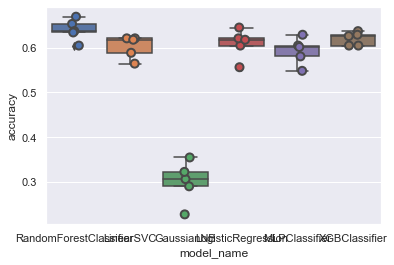

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 3), random_state=1)
models = [
    RandomForestClassifier(random_state=0),
    LinearSVC(),
    GaussianNB(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs',penalty='l2',C=0.1),
    NN,
    XGBClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [43]:
cv_df.groupby('model_name').accuracy.mean()

model_name
GaussianNB                0.300367
LinearSVC                 0.602609
LogisticRegression        0.609061
MLPClassifier             0.592906
RandomForestClassifier    0.639732
XGBClassifier             0.620365
Name: accuracy, dtype: float64

# Balance the dataset with synthetic samples (SMOTE)
In addition to being extremely small, our training dataset has the unbalanced target binary variable, which can undermine some models' predictability. We will perform an oversampling, which consists of creating new samples to increase the 0 minority class. For this we will use the SMOTE technique.

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbor



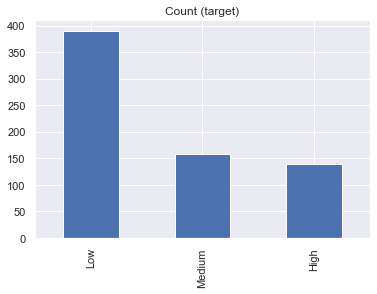

In [44]:
clean_reduced_df['Taux_corr_binned'].value_counts().plot(kind='bar', title='Count (target)')

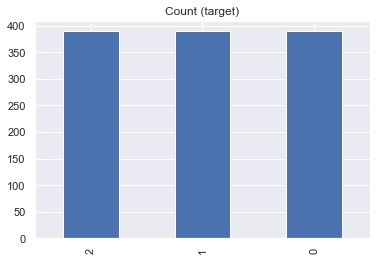

In [45]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto')
X_sm, y_sm = smote.fit_resample(X_pre, y_pre)

df = pd.DataFrame(X_sm)
df['target'] = y_sm

df['target'].value_counts().plot(kind='bar', title='Count (target)')

In [46]:
X_sm.shape

(1170, 44)

In [47]:
df['target'].unique()

array([2, 1, 0])

# Train_Test Split:

In [48]:
# Split the dataset and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.1)
print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))

117 rows in test set vs. 1053 in training set. 44 Features.


In [49]:
from sklearn.model_selection import GridSearchCV
# Set a range for n_estimators from 10 to 40 in steps of 10
param_grid = {'n_estimators': range(10, 50,10)}

# Optimize for a RandomForestClassifier() using GridSearchCV
grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid.fit(X_train, y_train)
grid.best_params_

{'n_estimators': 40}

In [50]:
grid.score(X_test, y_test)

0.811965811965812

In [51]:
# Define a grid for n_estimators ranging from 1 to 10
param_grid = {'n_estimators': range(1, 11)}

# Optimize for a AdaBoostClassifier() using GridSearchCV
grid = GridSearchCV(AdaBoostClassifier(), param_grid, cv=3)
grid.fit(X_train, y_train)
grid.best_params_

{'n_estimators': 4}

In [52]:
grid.score(X_test, y_test)

0.5726495726495726

In [53]:
 from sklearn.neighbors import KNeighborsClassifier
# Define a grid for n_neighbors with values 10, 50 and 100
param_grid = {'n_neighbors': [10,50,100]}

# Optimize for KNeighborsClassifier() using GridSearchCV
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
grid.fit(X_train, y_train)
grid.best_params_

{'n_neighbors': 10}

In [54]:
grid.score(X_test, y_test)

0.6239316239316239

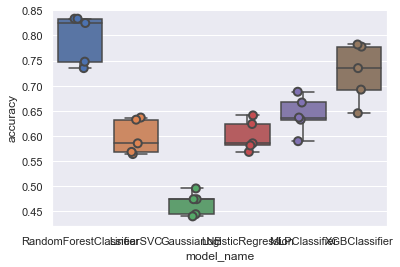

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 3), random_state=1)
models = [
    RandomForestClassifier( random_state=0),
    LinearSVC(),
    GaussianNB(),
    LogisticRegression(multi_class='multinomial', solver='lbfgs',penalty='l2',C=0.1),
    NN,
    XGBClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, df.drop('target',axis=1), df['target'], scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [56]:
cv_df.groupby('model_name').accuracy.mean()

model_name
GaussianNB                0.465812
LinearSVC                 0.597436
LogisticRegression        0.600000
MLPClassifier             0.642735
RandomForestClassifier    0.794872
XGBClassifier             0.726496
Name: accuracy, dtype: float64

# Stacking :
## Stacking model1 :EnsembleVoteClassifier

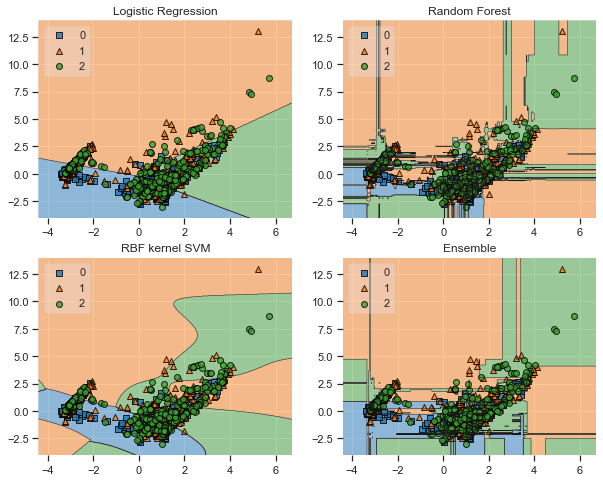

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import iris_data
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)
clf4=XGBClassifier()
eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3,clf4],
                              weights=[1, 2, 1,2], voting='soft')

pca = PCA(n_components=2)
X_reduced=pca.fit_transform(df.drop('target',axis=1).to_numpy())
# Plotting Decision Regions

gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

labels = ['Logistic Regression',
          'Random Forest',
          'RBF kernel SVM',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3,clf4, eclf],
                         labels,
                         itertools.product([0, 1],
                         repeat=2)):
    clf.fit(X_reduced, df['target'])
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_reduced, y=df['target'].to_numpy(),
                                clf=clf, legend=2)
    plt.title(lab)

plt.show()

In [60]:
eclf.fit(X_train, y_train)
eclf.score(X_test, y_test)

0.7692307692307693

## Second Model :StackingCVClassifier

In [61]:

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import warnings

warnings.simplefilter('ignore')

RANDOM_SEED = 42

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=RANDOM_SEED)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)
sclf.fit(X_train, y_train)
sclf.score(X_test, y_test)

0.811965811965812

# Using Probabilities as Meta-Features

Alternatively, the class-probabilities of the first-level classifiers can be used to train the meta-classifier (2nd-level classifier) by setting use_probas=True. For example, in a 3-class setting with 2 level-1 classifiers, these classifiers may make the following "probability" predictions for 1 training sample:

    classifier 1: [0.2, 0.5, 0.3]
    classifier 2: [0.3, 0.4, 0.4]

This results in k features, where k = [n_classes * n_classifiers], by stacking these level-1 probabilities:

    [0.2, 0.5, 0.3, 0.3, 0.4, 0.4]


In [67]:
from mlxtend.classifier import StackingClassifier
sclf_with_proba = StackingClassifier(classifiers=[clf1, clf2, clf3],
                          use_probas=True,
                          meta_classifier=lr)
sclf_with_proba.fit(X_train, y_train)
sclf_with_proba.score(X_test, y_test)

0.7863247863247863

## Stacking 3 :

In [68]:
from mlxtend.classifier import StackingClassifier

m = StackingClassifier(
    classifiers=[
        LogisticRegression(),
        XGBClassifier(max_depth=2),
        MLPClassifier()
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

m.fit(X_train, y_train)
m.score(X_test, y_test)

0.7777777777777778

## Using Sklearn :


In [70]:
from sklearn.ensemble import StackingClassifier 
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=42)))]
Sk_Stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
Sk_Stacking.fit(X_train, y_train)

Sk_Stacking.score(X_test, y_test)

0.811965811965812

# Deep learning Approch :
## Prepare Data :


In [82]:
## Deep Learning Approch :

y = y_sm
X = X_sm

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

#### Create the encoder.
## encoder = LabelEncoder()

#encoder.fit(y)   # Assume for simplicity all features are categorical.

#target_le = encoder.transform(y)

target_oh =tf.keras.utils.to_categorical(y)

print("target_le",y.shape)

print("target_oh",target_oh.shape)

#print(LabelEncoder().classes_)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(target_oh.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))


Dimensions of y before reshaping: (1170,)
Dimensions of X before reshaping: (1170, 44)
target_le (1170,)
target_oh (1170, 3)
Dimensions of y after reshaping: (1170, 3)
Dimensions of X after reshaping: (1170, 44)


# Define/Compile the model

In [86]:
# First define baseline model. Then use it in Keras Classifier for the training
def Classification_model():
    # Create model here
    model =tf.keras.Sequential()
    model.add(layers.Dense(15, input_dim = 44, activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(layers.Dense(15, activation = 'relu'))
    model.add(layers.Dense(3, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
Classification_Model = Classification_model()
Classification_Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 15)                675       
_________________________________________________________________
dense_10 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 48        
Total params: 963
Trainable params: 963
Non-trainable params: 0
_________________________________________________________________


In [87]:
EPOCHS =1000
# configure early stopping
es = EarlyStopping(monitor='val_loss',min_delta=0.0000000000001, patience=5)
#batch_size=1000

history = Classification_Model.fit(X,target_oh,batch_size=16,epochs=EPOCHS, validation_split = 0.1, verbose=0 ,callbacks=[es])

In [89]:
Classification_Model.save('Classification_Model.h5') 

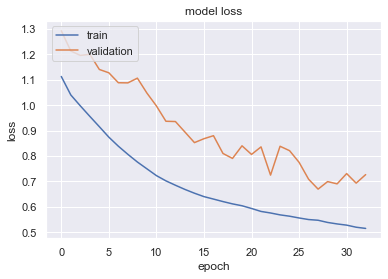

In [90]:
#Let’s see what this looks like when we plot our respective losses:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [91]:
# evaluate the keras model
loss, accuracy = Classification_Model.evaluate( X, target_oh, verbose=2)
print(" Accuracy".format(accuracy))

37/37 - 0s - loss: 0.5245 - accuracy: 0.7821
 Accuracy


In [92]:
X.shape

(1170, 44)

# Selected  ML :
we find :

    RandomForestClassifier =0.811965811965812
    Sk_Stacking = 0.8119657
    estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
        ('svr', make_pipeline(StandardScaler(),
                               LinearSVC(random_state=42)))]
    Sk_Stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
    
**They have similar accuracy so for simplicity and for performance  we chose RandomForestClassifier** 
## Retrain on all the data without  CV :

In [96]:
RFC=RandomForestClassifier()
RFC.fit(X_sm, y_sm)
RFC.score(X_sm, y_sm)

1.0

**As we see RFC is perfoming well but let's be aware of overfitting " 
In our CV = 0.811965811965812**